In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # suppress future warnings (about pandas.replace)

# 1. Data Preparation



In [4]:
# load the data
churn = pd.read_csv('churn.csv',sep=' ')

# convert COLLEGE as numeric
churn['COLLEGE'] = churn['COLLEGE'].replace({'zero':0, 'one':1}) 

# drop 4 categorical variables for simplicity 
churn.drop(columns = ['OVER_15MINS_CALLS_PER_MONTH', 
                      'REPORTED_SATISFACTION', 
                      'REPORTED_USAGE_LEVEL', 
                      'CONSIDERING_CHANGE_OF_PLAN'], 
           inplace = True)

churn.shape

(20000, 8)

**Split and Scale the Data**

In [5]:
# split data
X = churn.drop(columns = 'LEAVE')       # features
y = churn['LEAVE']                      # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)   
X_test_scaled  = scaler.transform(X_test)
display(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

(16000, 7)

(4000, 7)

(16000,)

(4000,)

# 2. Model Training and Evaluation


### 2.1 Modeling

Let's train two models and use the **default threshold (0.5)** for class prediction and evaluation.



**SVM**

Here we use the ``LinearSVC`` function (check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for details) as the ``SVC`` function takes a longer training time with a large dataset.   

In [6]:
svm = LinearSVC()              # default C=1.0

svm.fit(X_train_scaled,y_train)     

#svm1 = SVC(kernel = 'linear', probability = True).fit(X_train_scaled,y_train)   # enable probability estimation(default False)

svm.score(X_test_scaled,y_test)   # plain accuracy (based on default threshold 50%)

0.6425

**Decision Tree**

In [7]:
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5,  min_samples_leaf = 500, random_state = 1)    # arbitary hyparameter    

tree.fit(X_train_scaled, y_train)

tree.score(X_test_scaled,y_test)   # plain accuracy (based on default threshold 50%)

0.7085

### 2.2 Class Probability Estimation

As the ``linearSVC`` function doesn't have ``predict_proba`` method, we use ``_predict_proba_lr`` method to generate class probabilities. The methods transform the confidence scores (i.e., linear output) returned by the model with the logistic/sigmoid function. 
- If ``SVC(kernel = 'linear', probability = True)`` function was used in model training, we may use ``predict_proba`` for probability estimation.  

In [8]:
svm_prob = svm._predict_proba_lr(X_test_scaled)   

#svm_prob = svm1.predict_proba(X_test_scaled)    # if use SVC() 

svm_prob    # Probabilities of LEAVE, STAY

array([[0.58255641, 0.41744359],
       [0.58359051, 0.41640949],
       [0.39655491, 0.60344509],
       ...,
       [0.63035007, 0.36964993],
       [0.50280902, 0.49719098],
       [0.36338027, 0.63661973]])

In [9]:
tree_prob = tree.predict_proba(X_test_scaled)

tree_prob     

array([[0.80815348, 0.19184652],
       [0.80815348, 0.19184652],
       [0.2232906 , 0.7767094 ],
       ...,
       [0.71056911, 0.28943089],
       [0.79759863, 0.20240137],
       [0.12683824, 0.87316176]])

### 2.3 Classification with Customized Thresholds

Here we use the `numpy.where` function for class prediction.  Check [documentation](https://numpy.org/doc/stable/reference/generated/numpy.where.html) for details. 

In [10]:
# Predict with a different threshold (e.g., 0.8)

svm_pred = np.where(svm_prob[:,0] > 0.8, 'LEAVE', 'STAY')    # condition, result when True, result when False

sum(svm_pred == 'LEAVE')    # no positive predictions  

np.int64(0)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, svm_pred)                        
recall = recall_score(y_test, svm_pred, pos_label = 'LEAVE')        
#precision = precision_score(y_test, svm_pred, pos_label = 'LEAVE')   # no positive prediction
f1 = f1_score(y_test, svm_pred, pos_label = 'LEAVE') 

print('Accuracy(SVM): {:.2%}'.format(accuracy))                   
print('Recall(SVM): {:.2%}'.format(recall))   
#print('Precision(SVM): {:.2%}'.format(precision))     
print('F1(SVM): {:.2%}'.format(f1))

Accuracy(SVM): 51.38%
Recall(SVM): 0.00%
F1(SVM): 0.00%


<font color=red>***Exercise 1: Your Codes Here***</font>  

Please apply the **tree** model to predict test instances' class labels and check the evaluation metrics.  

- Use 0.8 as the cut-off as well. 

In [29]:
import numpy as np
import pandas as pd

# Ensure tree_prob is a NumPy array
tree_prob_arr = np.asarray(tree_prob)

# Predictions at threshold 0.8 as strings and numeric (to match y_test format)
tree_pred_str = np.where(tree_prob_arr[:, 0] > 0.8, 'LEAVE', 'STAY')
tree_pred_num = np.where(tree_prob_arr[:, 0] > 0.8, 1, 0)

# Choose prediction type depending on y_test dtype
if pd.api.types.is_numeric_dtype(y_test):
    preds = tree_pred_num
    pos_label = 1
else:
    preds = tree_pred_str
    pos_label = 'LEAVE'

accuracy_tree = accuracy_score(y_test, preds)
recall_tree = recall_score(y_test, preds, pos_label=pos_label)
precision_tree = precision_score(y_test, preds, pos_label=pos_label)
f1_tree = f1_score(y_test, preds, pos_label=pos_label)

print('Accuracy(Tree): {:.2%}'.format(accuracy_tree))
print('Recall(Tree): {:.2%}'.format(recall_tree))
print('Precision(Tree): {:.2%}'.format(precision_tree))
print('F1 Score(Tree): {:.2%}'.format(f1_tree))

Accuracy(Tree): 58.20%
Recall(Tree): 19.18%
Precision(Tree): 78.86%
F1 Score(Tree): 30.85%


# 3. Visualize Model Performance

## 3.1  ROC Curve 


### 3.1(a) Caculate TPR, FPR, and AUC


**Step 1**: compute **TPR** and **FPR** at different thresholds (**in decreasing order**) with the ``roc_curve`` function (check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) for details).

- ``y_true``: True binary labels (*ndarray of shape (n_samples,)*).

- ``y_score``: It can either be positive probability estimates or confidence values (*ndarray of shape (n_samples,)*).  

- ``pos_label``: The label of the positive class (int or str, default= ``None``). Should be explicitly given unless ``y_true`` is in {-1, 1} or {0, 1}.

Note this function is restricted to the binary classification task only.

In [12]:
from sklearn.metrics import roc_curve 
 
fpr_svm, tpr_svm, thresholds = roc_curve(y_true = y_test, 
                                         y_score = svm_prob[:,0],      #  first column for 'LEAVE'
                                         pos_label = 'LEAVE')    

display(fpr_svm, tpr_svm, thresholds)        

# When threhold decreases, both FPR and TPR increase (1st threshold = inf so tpr=fpr=0) 

array([0.        , 0.        , 0.        , ..., 0.99659367, 0.99659367,
       1.        ])

array([0.00000000e+00, 5.14138817e-04, 2.05655527e-03, ...,
       9.99485861e-01, 1.00000000e+00, 1.00000000e+00])

array([       inf, 0.74867689, 0.71823525, ..., 0.30938194, 0.3091085 ,
       0.28537532])

**Step 2**:  calculate **AUC** value.  

- With **TPR** and **FPR** scores, use the general  ``auc`` function to calculate the area size under any curve. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) for details.


In [13]:
from sklearn.metrics import auc
 
auc_svm = auc(x = fpr_svm, y = tpr_svm)    

auc_svm

0.7002080323244453

- Alternatively, use the `roc_auc_score` function with true labels and estimated probabilities. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) for details.

  Note the `y_score` parameter expects **the probability of the class with the greater label**, which is **'STAY'** in our data.


In [14]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true = y_test, y_score = svm_prob[:,1])    # y_score refers to 'STAY' probabilities

0.7002080323244453

### 3.1(b) Plot the ROC Curve

Visualize the **TPR** against **FPR** as a line using the `sklearn.metrics.RocCurveDisplay` class. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay) for details.


- Alternatively, we can use the `matplotlib.pyplot.plot` function.
  
Here we also visualize the random model as the diagonal line.
 

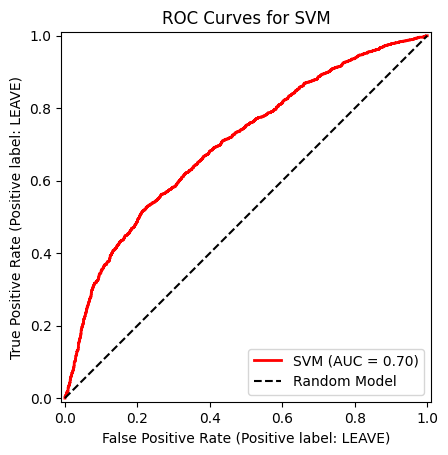

In [15]:
from sklearn.metrics import RocCurveDisplay

# step 1 - roc curve for svm 
disp = RocCurveDisplay(fpr = fpr_svm, tpr = tpr_svm, roc_auc = auc_svm, pos_label = 'LEAVE', name='SVM')
disp.plot(color = 'red', linewidth = 2)

# step 2 - roc curve for random model 
plt.plot([0, 1], [0, 1], color = 'black', linewidth= 1.5, linestyle='--', label = 'Random Model')    

# adjust title and legend position
plt.title('ROC Curves for SVM')
plt.legend(loc='lower right')
plt.show()

**The following approaches are recommended as as more convient alternatives.**


- Option 1: plot ROC curve given an estimator and the data with `RocCurveDisplay.from_estimator` function (check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_estimator) for details).

```python

RocCurveDisplay.from_estimator(estimator = svm, 
                               X = X_test_scaled, 
                               y = y_test, 
                               pos_label = 'LEAVE', 
                               name = 'SVM', 
                               color = 'red',
                               linewidth = 2)
plt.show()
```

- Option 2: plot ROC curve given true and predicted value with `RocCurveDisplay.from_predictions` function (check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions) for details).

```python

RocCurveDisplay.from_predictions(y_true = y_test, 
                                 y_pred = svm_prob[:,0],    # positive probabilities or confidence scores
                                 pos_label = 'LEAVE',
                                 name = 'SVM', 
                                 color = 'red',
                                 linewidth = 2)
plt.show()                                 
```




<font color=red>***Exercise 2: Your Codes Here***</font>  

Please plot the ROC curve for the **tree** model.  



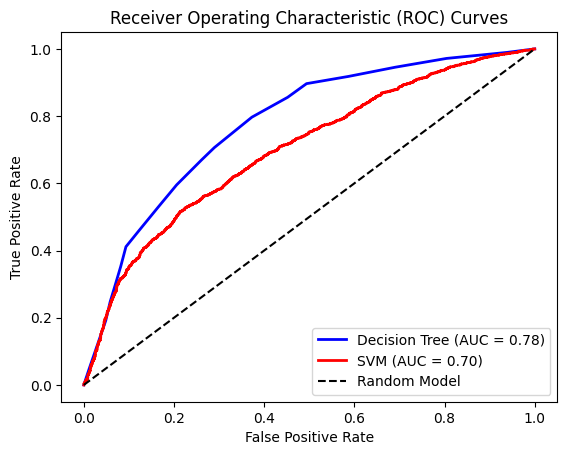

In [32]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for the tree model
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_prob[:, 0], pos_label=pos_label)
roc_auc_tree = auc(fpr_tree, tpr_tree)
# Plot ROC curve for the tree model
plt.plot(fpr_tree, tpr_tree, color='blue', linewidth=2, label='Decision Tree (AUC = {:.2f})'.format(roc_auc_tree))
# Add SVM ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_prob[:, 0], pos_label=pos_label)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, color='red', linewidth=2, label='SVM (AUC = {:.2f})'.format(roc_auc_svm))
# Add random model line
plt.plot([0, 1], [0, 1], color='black', linewidth=1.5, linestyle='--', label='Random Model')
# Adjust title and legend position
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## 3.2 Cumulative Response Curve  (CRC)

The `scikit-learn` package doesn't support CRC directly, we will use`matplotlib` package with some data preparation.

### 3.2(a) Sort instances according to the decreasing order of scores 

In [16]:
df = pd.DataFrame({'y_prob': svm_prob[:,0], 'y_test': y_test})

df = df.sort_values(by = 'y_prob', ascending = False)   # sort by score (in decreasing order)

df.head()

,y_prob,y_test
8036,0.748677,LEAVE
19402,0.730696,LEAVE
4102,0.720823,LEAVE
3490,0.718235,LEAVE
8197,0.713805,STAY


### 3.2(b) Calculate TPR & %Pos Predictions at different thresholds 

- Here we consider instance's probability as a threshold. 
- When threshold deceases, both  TPR & %Positive Predictions increase. 

In [17]:
# % pos predictions at different thresholds  

total_predictions = df.shape[0]                                             # number of predictions (4000)  

pos_pred = np.arange(1, df.shape[0] + 1) / total_predictions                # % pos predictions 

pos_pred

array([2.5000e-04, 5.0000e-04, 7.5000e-04, ..., 9.9950e-01, 9.9975e-01,
       1.0000e+00])

In [18]:
# TPR (cumulative response) at different thresholds 

total_positives = np.sum(df['y_test']  == 'LEAVE')                  # number of true postives (p)

tpr = np.cumsum(df['y_test'] == 'LEAVE') / total_positives          # tpr (cumulative response)  

tpr

8036     0.000514
19402    0.001028
4102     0.001542
3490     0.002057
8197     0.002057
           ...   
17831    1.000000
206      1.000000
16824    1.000000
1228     1.000000
11161    1.000000
Name: y_test, Length: 4000, dtype: float64

### 3.2(c) Plot the CRC curve

The x-axis displays the **%Pos Predictions** and y-axis shows the corresponding **TPR(Cumulative Response)**.

- Here we use the `matplotlib.pyplot.plot` fuction to visualize a line. Check [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) for details.  

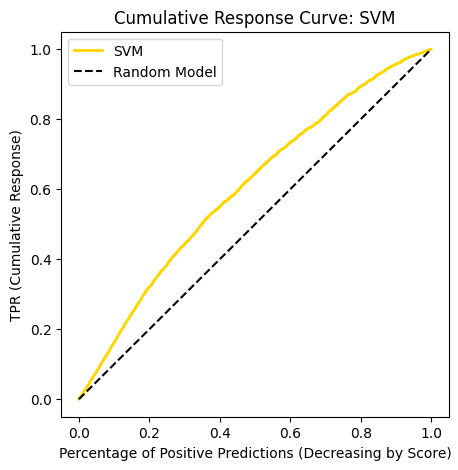

In [19]:
plt.figure(figsize=(5,5))
plt.plot(pos_pred, tpr, color = 'gold', linewidth=2, label = 'SVM')                                    # SVM
plt.plot([0, 1], [0, 1], color = 'black', linewidth= 1.5, linestyle='--', label = 'Random Model')      # random model  
plt.xlabel('Percentage of Positive Predictions (Decreasing by Score)')
plt.ylabel('TPR (Cumulative Response)')
plt.title('Cumulative Response Curve: SVM')
plt.legend()
plt.show()

## 3.3 Lift Curve  

Again, we use `matplotlib.pyplot.plot` function to visualize a line, with a bit data preparation. 

- We also visualize the lift value for random model as a horizontal line using the `matplotlib.pyplot.axhline` fuction. Check [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html) for details.  

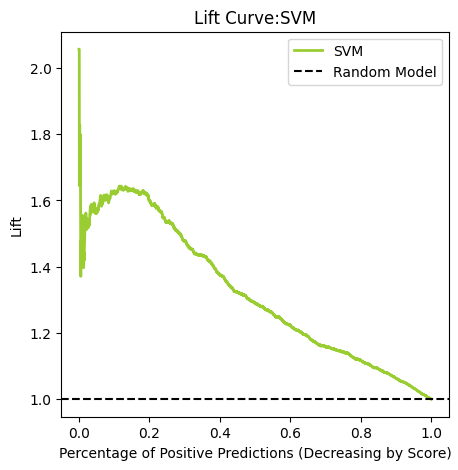

In [20]:
# Calculate lift values at different thresholds (tpr/%Y)
lifts = tpr/pos_pred     

# Plot the lift curve
plt.figure(figsize=(5,5))
plt.plot(pos_pred, lifts, color = 'yellowgreen', linewidth=2,  label='SVM')                       # lift for SVM
plt.axhline(y = 1, linestyle = '--', color = 'black', linewidth= 1.5, label = 'Random Model')     # lift for random model
plt.xlabel('Percentage of Positive Predictions (Decreasing by Score)')
plt.ylabel('Lift')
plt.title('Lift Curve:SVM')
plt.legend()
plt.show()

<font color=red>***Exercise 3: Your Codes Here***</font>  

Would you please visualize the CRC curve and Lift curve for the **tree** model?

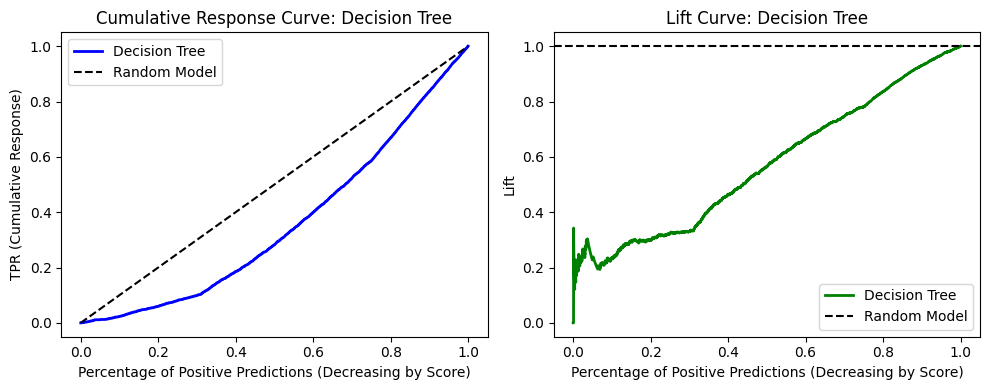

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Align positive label between the true labels and the tree's class ordering.
if 'pos_label' in globals():
    positive_label = pos_label
else:
    unique_labels = pd.unique(y_test)
    if 'LEAVE' in unique_labels:
        positive_label = 'LEAVE'
    elif pd.api.types.is_numeric_dtype(y_test):
        positive_label = np.max(unique_labels)
    else:
        numeric_labels = pd.to_numeric(unique_labels, errors='coerce')
        if not np.isnan(numeric_labels).all():
            max_numeric = np.nanmax(numeric_labels)
            positive_label = unique_labels[numeric_labels == max_numeric][0]
        else:
            positive_label = unique_labels[0]

classes_list = list(tree.classes_)
if positive_label in classes_list:
    pos_idx = classes_list.index(positive_label)
else:
    # Fallback to the last probability column when label types do not align
    pos_idx = tree_prob.shape[1] - 1 if tree_prob.ndim == 2 else 0

# Prepare sorted dataframe for tree probabilities using the selected probability column
df_tree = pd.DataFrame({'y_prob': tree_prob[:, pos_idx], 'y_test': y_test})
# sort by predicted probability (decreasing) and reset index to ensure consistent ordering
df_tree = df_tree.sort_values(by='y_prob', ascending=False).reset_index(drop=True)

# % positive predictions (decreasing by score)
total_predictions = df_tree.shape[0]
pos_pred_tree = np.arange(1, total_predictions + 1) / total_predictions

# TPR (cumulative response) - guard against zero positives
total_positives = np.sum(df_tree['y_test'] == positive_label)
if total_positives == 0:
    print(f"Warning: no positive labels ({positive_label}) found in y_test. TPR will be zeros.")
    tpr_tree = np.zeros_like(pos_pred_tree)
else:
    tpr_tree = np.cumsum(df_tree['y_test'] == positive_label) / total_positives

# Plot CRC and Lift side-by-side
plt.figure(figsize=(10,4))

# CRC
plt.subplot(1,2,1)
plt.plot(pos_pred_tree, tpr_tree, color='blue', linewidth=2, label='Decision Tree')
plt.plot([0, 1], [0, 1], color='black', linewidth=1.5, linestyle='--', label='Random Model')
plt.xlabel('Percentage of Positive Predictions (Decreasing by Score)')
plt.ylabel('TPR (Cumulative Response)')
plt.title('Cumulative Response Curve: Decision Tree')
plt.legend()

# Lift
plt.subplot(1,2,2)
# Avoid extreme division by very small first element; use a safe copy for division
safe_pos = pos_pred_tree.copy()
safe_pos[0] = max(safe_pos[0], 1 / total_predictions)
lifts_tree = tpr_tree / safe_pos
plt.plot(pos_pred_tree, lifts_tree, color='green', linewidth=2, label='Decision Tree')
plt.axhline(y=1, linestyle='--', color='black', linewidth=1.5, label='Random Model')
plt.xlabel('Percentage of Positive Predictions (Decreasing by Score)')
plt.ylabel('Lift')
plt.title('Lift Curve: Decision Tree')
plt.legend()

plt.tight_layout()
plt.show()



# 4. Hyperparameter Tuning 


With different business goals, we may use different evaluation metrics in hyperparameter tuning. Pay attention to the following parameter in `GridSearchCV` :  

- `scoring`: the evaluation metric(s) used to compare parameters/models in cross-validatation. `Default` = None, which use `'accuracy'` for classification models. It takes a single string (or a callable,list, tuple or dict), which can be  `'accuracy'`,  `'precision'`, `'recall'`, `'f1'`, etcs. Check [this link](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for available values.

Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for details.

In [21]:
# Step 1: convert target as numbers so the positive is numerically bigger: 0(STAY) or 1(LEAVE)

y_train = y_train.replace({'LEAVE':1, 'STAY':0})
y_test = y_test.replace({'LEAVE':1, 'STAY':0})   

In [22]:
# Step 2: GridSearch by roc_auc

from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(criterion = 'entropy', random_state = 1)   # set the criterion only

param_range = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'min_samples_leaf':[100, 200, 300, 400, 500]}    # 10*5

grid = GridSearchCV(estimator = model, 
                    param_grid = param_range, 
                    cv = 5, 
                    scoring = 'roc_auc')                       

grid.fit(X_train_scaled, y_train)        

print("Best params: ", grid.best_params_)    
print("Mean cv score (auc) for the best params: {:.2%}".format(grid.best_score_))   

Best params:  {'max_depth': 7, 'min_samples_leaf': 100}
Mean cv score (auc) for the best params: 76.81%


Again, different scores are returned with the following two approaches.    

In [23]:
grid.score(X_test_scaled, y_test)   # auc (same score used in GridsearchCV)

0.7751398244922721

In [24]:
best = grid.best_estimator_   

best.score(X_test_scaled, y_test)   # accuracy (the default)

0.70125

Alternatively, calculate the AUC value of the best model using `sklearn.metrics.roc_auc_score` function. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) for details.

```python
from sklearn.metrics import roc_auc_score
best = grid.best_estimator_     
best_prob = best.predict_proba(X_test_scaled)
roc_auc_score(y_test, best_prob[:, 1])   #  probabilities for the class with the greater label (1)
```

<font color=red>***Exercise 4: Your Codes Here***</font>  

Please visualize the ROC curve for the best model.  Try to answer:  **Which threshold is the best one?** or **How many customers should be targeted?**

- In case the ROC curve doesn't give you actional insight,  try CRC curve.

Best model ROC AUC: 0.7751
Recommended threshold (Youden's J): 0.4651
TPR at this threshold: 82.78%
FPR at this threshold: 40.00%
Number of customers to target: 2432 (4000 of total, 60.80%)


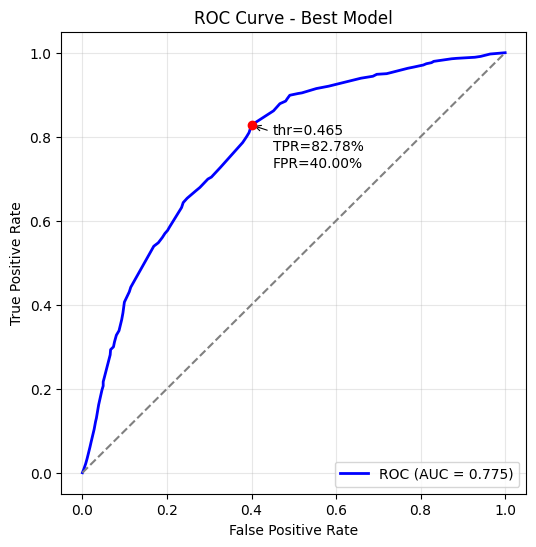

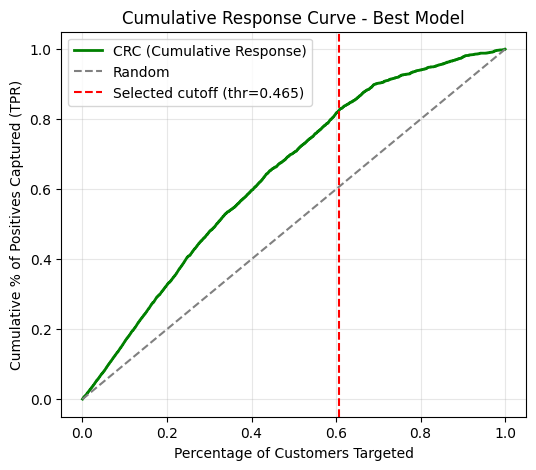

In [ ]:
# Compute ROC for the best model and identify optimal threshold (Youden's J)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# best is assumed to be grid.best_estimator_
best = grid.best_estimator_
# predicted probabilities for the positive class (label=1)
best_prob = best.predict_proba(X_test_scaled)
probs_pos = best_prob[:, 1]

# ROC
fpr_b, tpr_b, thresholds_b = roc_curve(y_test, probs_pos, pos_label=1)
roc_auc_b = auc(fpr_b, tpr_b)

# Youden's J statistic to choose optimal threshold
j_scores = tpr_b - fpr_b
best_idx = np.argmax(j_scores)
best_threshold = thresholds_b[best_idx]
best_tpr = tpr_b[best_idx]
best_fpr = fpr_b[best_idx]

# Number/percentage of customers to target at this threshold
n_customers = len(probs_pos)
n_target = np.sum(probs_pos >= best_threshold)
pct_target = n_target / n_customers

# Print concise summary
print('Best model ROC AUC: {:.4f}'.format(roc_auc_b))
print('Recommended threshold (Youden\'s J): {:.4f}'.format(best_threshold))
print('TPR at this threshold: {:.2%}'.format(best_tpr))
print('FPR at this threshold: {:.2%}'.format(best_fpr))
print('Number of customers to target: {} ({} of total, {:.2%})'.format(n_target, n_customers, pct_target))

# Plot ROC and mark the optimal point
plt.figure(figsize=(6,6))
plt.plot(fpr_b, tpr_b, color='blue', lw=2, label='ROC (AUC = {:.3f})'.format(roc_auc_b))
plt.plot([0,1], [0,1], color='grey', linestyle='--')
plt.scatter(best_fpr, best_tpr, color='red', zorder=5)
plt.annotate('thr={:.3f}\nTPR={:.2%}\nFPR={:.2%}'.format(best_threshold, best_tpr, best_fpr),
             (best_fpr, best_tpr), xytext=(best_fpr+0.05, best_tpr-0.10),
             arrowprops=dict(arrowstyle='->', lw=0.8))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Model')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Cumulative Response Curve (CRC) to show how many positives captured when targeting top probabilities
import pandas as pd

df_best = pd.DataFrame({'prob': probs_pos, 'y_test': y_test})
df_best = df_best.sort_values(by='prob', ascending=False).reset_index(drop=True)
total_positives = np.sum(df_best['y_test'] == 1)

if total_positives > 0:
    cum_tp = np.cumsum(df_best['y_test'] == 1) / total_positives
    pct_pos_preds = (np.arange(1, len(df_best) + 1) / len(df_best))

    # find index corresponding to chosen threshold in the sorted list
    selected_idx = np.where(df_best['prob'] >= best_threshold)[0]
    if selected_idx.size > 0:
        idx_cut = selected_idx[-1]
        pct_target_by_crc = (idx_cut + 1) / len(df_best)
    else:
        pct_target_by_crc = 0.0

    # Plot CRC and mark selected cutoff
    plt.figure(figsize=(6,5))
    plt.plot(pct_pos_preds, cum_tp, color='green', lw=2, label='CRC (Cumulative Response)')
    plt.plot([0,1], [0,1], color='grey', linestyle='--', label='Random')
    plt.axvline(pct_target_by_crc, color='red', linestyle='--', label='Selected cutoff (thr={:.3f})'.format(best_threshold))
    plt.xlabel('Percentage of Customers Targeted')
    plt.ylabel('Cumulative % of Positives Captured (TPR)')
    plt.title('Cumulative Response Curve - Best Model')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    print('No positive labels found in y_test; CRC cannot be computed.')
    